In [1]:
# Import libraries
import pandas as pd
import numpy as np
import re, string, warnings
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score
warnings.filterwarnings("ignore")

In [3]:
df1 = pd.read_csv("malicious_phish.csv")
df2 = pd.read_csv("data.csv")
df3 = pd.read_csv("Malicious-URLs.csv")
df_real = pd.read_csv("cleaned_topreal_urls.csv")
df_real['label'] = 'benign'

In [4]:
## Replicate the real URL data n times to emphasize its weight
n_replications = 3  # Adjust this value to set the "weight"
df_real_weighted = pd.concat([df_real] * n_replications, ignore_index=True)

In [5]:
# Standardize column names
df1 = df1[['url', 'type']].rename(columns={'type': 'label'})
df2.columns = ['url', 'label']
df3 = df3[['url', 'type']].rename(columns={'type': 'label'})

In [6]:
# Combine datasets using the weighted real URLs
df = pd.concat([df1, df2, df3, df_real_weighted], ignore_index=True)
print(f" Combined dataset shape (before filtering): {df.shape}")

# Merge defacement with malicious (adding defacement to malicious)
df['label'] = df['label'].replace({'phishing': 'malicious', 'malware': 'malicious', 'defacement': 'malicious'})

# Filter to binary classes (malicious and benign)
df = df[df['label'].isin(['malicious', 'benign'])].copy()
print(f" Filtered dataset shape (binary): {df.shape}")
print(" Label distribution:\n", df['label'].value_counts())

whitelist_domains = set(df_real['url'].str.lower())
def is_whitelisted(url):
    domain = urlparse(url).netloc.lower()
    return int(domain in whitelist_domains)


# Feature Engineering
def get_url_length(url): return len(url.replace("http://", "").replace("https://", "").replace("www.", ""))
def count_letters(url): return sum(char.isalpha() for char in url)
def count_digits(url): return sum(char.isdigit() for char in url)
def count_special_chars(url): return sum(char in string.punctuation for char in url)
def has_shortening_service(url):
    pattern = re.compile(r'bit\.ly|goo\.gl|tinyurl|ow\.ly|t\.co|tr\.im|is\.gd|cli\.gs|j\.mp|bit\.do')
    return int(bool(pattern.search(url)))
def has_ip(url): return int(bool(re.search(r'\d{1,3}(?:\.\d{1,3}){3}', url)))
def keyword_score(url):
    keywords = ['login', 'verify', 'account', 'secure', 'update', 'bank', 'free']
    return sum(word in url.lower() for word in keywords)
def abnormal_url(url): return int(urlparse(url).netloc in url)
def secure_http(url): return int(urlparse(url).scheme == 'https')

# Apply feature functions
df['url_len'] = df['url'].apply(get_url_length)
df['letters_count'] = df['url'].apply(count_letters)
df['digits_count'] = df['url'].apply(count_digits)
df['special_chars_count'] = df['url'].apply(count_special_chars)
df['shortened'] = df['url'].apply(has_shortening_service)
df['abnormal_url'] = df['url'].apply(abnormal_url)
df['secure_http'] = df['url'].apply(secure_http)
df['has_ip'] = df['url'].apply(has_ip)
df['suspicious_keywords'] = df['url'].apply(keyword_score)
df['is_whitelisted'] = df['url'].apply(is_whitelisted)


# Balance dataset with a 2:1 ratio (benign:malicious)
from sklearn.utils import resample

# Separate classes
df_malicious = df[df['label'] == 'malicious']
df_benign = df[df['label'] == 'benign']

# If there are fewer benign URLs than the desired number, use all available benign URLs
n_benign = len(df_malicious) * 2
if len(df_benign) < n_benign:
    print(f"Only {len(df_benign)} benign URLs available. Using all benign URLs.")
    df_benign = df_benign.sample(n=len(df_benign), random_state=42)  # Use all benign URLs
else:
    df_benign = df_benign.sample(n=n_benign, random_state=42)  # Sample with a 2:1 ratio

# Combine & shuffle
df_balanced = pd.concat([df_malicious, df_benign]).sample(frac=1, random_state=42).reset_index(drop=True)

# Recompute features and labels (include is_whitelisted!)
X = df_balanced[['url_len', 'letters_count', 'digits_count', 'special_chars_count',
                 'shortened', 'abnormal_url', 'secure_http', 'has_ip', 'suspicious_keywords', 'is_whitelisted']]

y = df_balanced['label']

print(" Balanced Label Distribution:\n", y.value_counts())

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train model
pipeline = Pipeline([('classifier', ExtraTreesClassifier(random_state=42))])
pipeline.fit(X_train, y_train)

# Evaluate
y_pred = pipeline.predict(X_test)
print("\n Classification Report:\n")
print(classification_report(y_test, y_pred))

print(" Accuracy:", accuracy_score(y_test, y_pred))

 Combined dataset shape (before filtering): (1124405, 2)
 Filtered dataset shape (binary): (703941, 2)
 Label distribution:
 label
benign       467522
malicious    236419
Name: count, dtype: int64
Only 467522 benign URLs available. Using all benign URLs.
 Balanced Label Distribution:
 label
benign       467522
malicious    236419
Name: count, dtype: int64

 Classification Report:

              precision    recall  f1-score   support

      benign       0.93      0.98      0.96     93505
   malicious       0.95      0.86      0.91     47284

    accuracy                           0.94    140789
   macro avg       0.94      0.92      0.93    140789
weighted avg       0.94      0.94      0.94    140789

 Accuracy: 0.9392708237149209


In [7]:
import pandas as pd
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score

def retrain_with_whitelist_feedback(df, df_real, current_whitelist):
    #Update whitelist function dynamically
    def is_whitelisted(url):
        domain = urlparse(url).netloc.lower().replace("www.", "")
        return int(domain in current_whitelist)

    #whitelist flag
    df['is_whitelisted'] = df['url'].apply(is_whitelisted)

    #Remove whitelisted malicious URLs
    before_removal = len(df[df['label'] == 'malicious'])
    df_filtered = df[~((df['label'] == 'malicious') & (df['is_whitelisted'] == 1))].copy()
    after_removal = len(df_filtered[df_filtered['label'] == 'malicious'])

    #Feature extraction
    feature_cols = ['url_len', 'letters_count', 'digits_count', 'special_chars_count',
                    'shortened', 'abnormal_url', 'secure_http', 'has_ip', 'suspicious_keywords', 'is_whitelisted']
    X = df_filtered[feature_cols]
    y = df_filtered['label']

    #Balance dataset (2:1 benign:malicious)
    df_malicious = df_filtered[df_filtered['label'] == 'malicious']
    df_benign = df_filtered[df_filtered['label'] == 'benign']
    n_benign = len(df_malicious) * 2

    if len(df_benign) < n_benign:
        df_benign = df_benign.sample(n=len(df_benign), random_state=42)
    else:
        df_benign = df_benign.sample(n=n_benign, random_state=42)

    df_balanced = pd.concat([df_malicious, df_benign]).sample(frac=1, random_state=42).reset_index(drop=True)

    X_bal = df_balanced[feature_cols]
    y_bal = df_balanced['label']

    #Split and Train
    X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)
    pipeline = Pipeline([('classifier', ExtraTreesClassifier(random_state=42))])
    pipeline.fit(X_train, y_train)

    #Predict and extract new false positives
    y_pred = pipeline.predict(X_test)
    false_positives = X_test[(y_pred == 'malicious') & (y_test == 'benign')]
    false_positive_urls = df_balanced.loc[false_positives.index, 'url'].dropna().unique()
    new_domains = set(pd.Series(false_positive_urls).apply(lambda x: urlparse(x).netloc.lower().replace("www.", "")))

    #Update whitelist
    updated_whitelist = current_whitelist.union(new_domains)

    #Evaluation
    report = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return pipeline, report, accuracy, before_removal, after_removal, updated_whitelist

current_whitelist = set(df_real['url'].apply(lambda x: urlparse(x).netloc.lower().replace("www.", "")))

pipeline = None

for i in range(3):
    print(f"\n Retraining Iteration {i + 1}")
    pipeline, report, acc, before, after, current_whitelist = retrain_with_whitelist_feedback(df, df_real, current_whitelist)
    print(" Malicious URLs before removing whitelisted:", before)
    print(" Malicious URLs after removing whitelisted:", after)
    print("\n New Evaluation:\n", report)
    print(" Accuracy:", acc)


 Retraining Iteration 1
 Malicious URLs before removing whitelisted: 236419
 Malicious URLs after removing whitelisted: 236292

 New Evaluation:
               precision    recall  f1-score   support

      benign       0.93      0.98      0.96     93505
   malicious       0.95      0.86      0.91     47258

    accuracy                           0.94    140763
   macro avg       0.94      0.92      0.93    140763
weighted avg       0.94      0.94      0.94    140763

 Accuracy: 0.9394798348997961

 Retraining Iteration 2
 Malicious URLs before removing whitelisted: 236419
 Malicious URLs after removing whitelisted: 163628

 New Evaluation:
               precision    recall  f1-score   support

      benign       1.00      1.00      1.00     65451
   malicious       1.00      1.00      1.00     32726

    accuracy                           1.00     98177
   macro avg       1.00      1.00      1.00     98177
weighted avg       1.00      1.00      1.00     98177

 Accuracy: 0.997514692

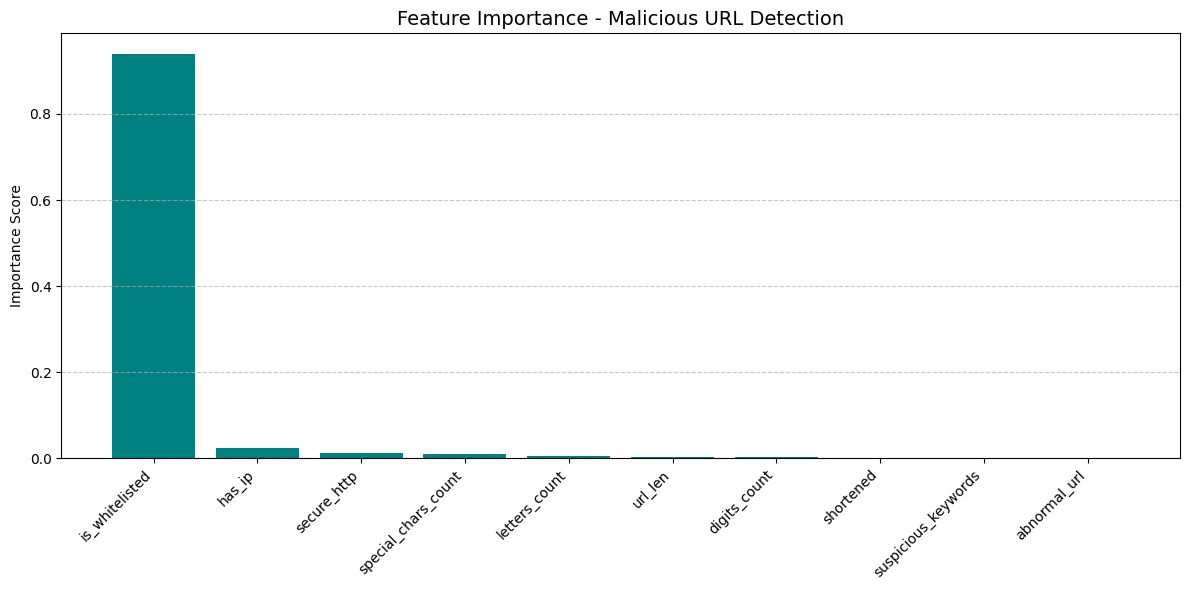

In [8]:
import matplotlib.pyplot as plt

# Extract feature importances
feature_names = X.columns
importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importance - Malicious URL Detection", fontsize=14)
bars = plt.bar(range(len(importances)), importances[indices], align='center', color='teal')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.ylabel("Importance Score")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [17]:
from urllib.parse import urlparse
import pandas as pd

# Ensure updated whitelist is used
def is_whitelisted(url):
    domain = urlparse(url).netloc.lower()
    domain = domain.replace("www.", "")  # Normalize domain
    return int(domain in current_whitelist)


# Validate URL
def is_valid_url(url):
    try:
        result = urlparse(url)
        return all([result.scheme, result.netloc])
    except:
        return False

# Extract features from a single URL
def extract_features_from_url(url):
    return pd.DataFrame([{
        'url_len': get_url_length(url),
        'letters_count': count_letters(url),
        'digits_count': count_digits(url),
        'special_chars_count': count_special_chars(url),
        'shortened': has_shortening_service(url),
        'abnormal_url': abnormal_url(url),
        'secure_http': secure_http(url),
        'has_ip': has_ip(url),
        'suspicious_keywords': keyword_score(url),
        'is_whitelisted': is_whitelisted(url)
    }])

# Ensure labels are mapped correctly
label_mapping = {'benign': 'Safe can be Trusted', 'malicious': "Doesn't seem to be trustful"}

# Prompt for user input
user_url = input("🔍 Enter a URL to check if it's safe (e.g., https://example.com): ").strip()

if is_valid_url(user_url):
    print(f" Checking domain: {urlparse(user_url).netloc.lower()}")

    user_features = extract_features_from_url(user_url)

    # Feature check to avoid pipeline mismatch
    expected_features = ['url_len', 'letters_count', 'digits_count', 'special_chars_count',
                         'shortened', 'abnormal_url', 'secure_http', 'has_ip',
                         'suspicious_keywords', 'is_whitelisted']
    if list(user_features.columns) != expected_features:
        print(" Feature mismatch! Please ensure the model was trained with the same features.")
    else:
        prediction = pipeline.predict(user_features)[0]
        print(f" Prediction: {label_mapping[prediction]}")
else:
    print(" Invalid input. Please enter a properly formatted URL (e.g., https://example.com)")

🔍 Enter a URL to check if it's safe (e.g., https://example.com): https://www.youtube.com/
 Checking domain: www.youtube.com
 Prediction: Safe can be Trusted
